# Add `previous_` features

`previous`는 어떤 사람이 어떤 테스트를 볼 때, 바로 직전에 푼 문제 (하나 전 row)와 지금 푸는 문제 (현재 row) 사이에 어떤 관계가 있는지 feature로 나타낸다. 

예를 들어 현재 푸는 문제의 번호가 바로 직전에 푼 문제 번호의 다음인지 (즉, 문제를 순서대로 풀고 있는지) 아니면 직전에 뒤의 문제에서 현재 앞의 문제로 이동한 것인지 등을 나타낸다. 

In [1]:
import os, sys
from pathlib import Path
from glob import glob

In [2]:
BASE_PATH = Path('.').resolve().parent
BASE_PATH

PosixPath('/opt/ml')

In [3]:
if BASE_PATH.as_posix() not in sys.path:
    sys.path.append(BASE_PATH.as_posix())

In [4]:
sys.path

['/opt/ml/jaepil',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/transformers-4.6.1-py3.8.egg',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/opt/ml/.ipython',
 '/opt/ml']

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd

In [7]:
import numba
import dask.dataframe as dd

In [8]:
import json
import pickle

In [9]:
from tqdm import tqdm, trange
# from tqdm.notebook import tqdm
from time import time

In [10]:
tqdm.pandas()

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.6.0'

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # Always check cudatoolkit version!

device(type='cuda', index=0)

In [13]:
from collections import defaultdict

## Load data

`['user_id', 'Timestamp']`로 sorting되고

`Timestamp`가 `datetime64` type으로 변환되었으며

`testId`에서 대분류인 `test_cat`을 뽑아내고

`assessmentItemID`에서 문제번호인 `question_num`을 뽑아낸

상태로 저장된 `train_df` 피클을 불러온다. 

In [29]:
train_df = pd.read_pickle('train_df.pkl')

## `previous` feature

우선 각 학생의 각 테스트 기준으로 previous를 구할 것이므로 user와 test로 groupby해준다. 

In [30]:
stu_test_groupby = train_df.groupby(['userID', 'testId'])

한 학생이 두 번 이상 같은 테스트를 본 경우 어느 row에서 끊어줘야 하는지 알 수 있게 하기 위해 단순 Timestamp diff를 한다. (즉, 진짜 delta를 보려는 용도가 아니라 끊어줄 지점을 알기 위한 delta)

In [31]:
%%time

train_df.loc[:, "delta"] = stu_test_groupby['Timestamp'].diff()

CPU times: user 1min 41s, sys: 1.55 s, total: 1min 43s
Wall time: 1min 43s


### `is_previous_ordered` 

현재 문제가 이전에 푼 문제의 바로 직후 문제번호를 가지는지 확인한다. 

In [32]:
train_df['q_num_prev'] = train_df.question_num.shift()

In [33]:
def is_previous_ordered(row):
    q_num = row.question_num
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num == q_num_prev + 1:
        return 1
    else:
        return 0
        

In [34]:
%%time

train_df['is_previous_ordered'] =  train_df.progress_apply(lambda row: is_previous_ordered(row), axis=1)
train_df.head()

100%|██████████| 2266586/2266586 [02:54<00:00, 12972.70it/s]

CPU times: user 2min 53s, sys: 1.57 s, total: 2min 54s
Wall time: 2min 54s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,delta,q_num_prev,is_previous_ordered
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,1,NaT,NaN,-1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,2,0 days 00:00:03,1.0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,3,0 days 00:00:08,2.0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,4,0 days 00:00:07,3.0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,5,0 days 00:00:07,4.0,1


In [35]:
def is_previous_decreasing(row):
    q_num = row.question_num
    q_num_prev = row.q_num_prev
    delta = row.delta
    delta_thres = 1 # hour
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif q_num < q_num_prev:
        return 1
    else:
        return 0

In [36]:
%%time

train_df['is_previous_decreasing'] = train_df.progress_apply(lambda row: is_previous_decreasing(row), axis=1)
train_df.head()

100%|██████████| 2266586/2266586 [02:54<00:00, 13010.86it/s]

CPU times: user 2min 52s, sys: 1.64 s, total: 2min 54s
Wall time: 2min 54s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,delta,q_num_prev,is_previous_ordered,is_previous_decreasing
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,1,NaT,NaN,-1,-1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,2,0 days 00:00:03,1.0,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,3,0 days 00:00:08,2.0,1,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,4,0 days 00:00:07,3.0,1,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,5,0 days 00:00:07,4.0,1,0


In [37]:
train_df['is_prev_ord_shift'] = train_df.is_previous_ordered.shift()
train_df['is_prev_dec_shift'] = train_df.is_previous_decreasing.shift()

In [38]:
train_df.head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,delta,q_num_prev,is_previous_ordered,is_previous_decreasing,is_prev_ord_shift,is_prev_dec_shift
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,1,NaT,NaN,-1,-1,NaN,NaN
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,2,0 days 00:00:03,1.0,1,0,-1.0,-1.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,3,0 days 00:00:08,2.0,1,0,1.0,0.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,4,0 days 00:00:07,3.0,1,0,1.0,0.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,5,0 days 00:00:07,4.0,1,0,1.0,0.0
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,6,7,0 days 00:00:11,5.0,0,0,1.0,0.0
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6,1,NaT,7.0,-1,-1,0.0,0.0
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,6,2,0 days 00:00:07,1.0,1,0,-1.0,-1.0
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,6,3,0 days 00:01:04,2.0,1,0,1.0,0.0
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,6,4,0 days 00:00:15,3.0,1,0,1.0,0.0


In [39]:
def is_probably_difficult(row):
    delta = row.delta
    delta_thres = 1 # hour
    
    is_prev_ord = row.is_previous_ordered
    is_prev_dec = row.is_previous_decreasing
    is_prev_ord_shift = row.is_prev_ord_shift
    is_prev_dec_shift = row.is_prev_dec_shift
    
    case = (is_prev_ord_shift, is_prev_dec_shift, is_prev_ord, is_prev_dec)
    
    probably_easy_l = [
        (np.nan, np.nan, -1, -1),
        (-1, -1, 1, 0),
        (1, 0, 1, 0),
        (1, 0, 0, 0),
        (0, 0, 1, 0),
    ]
    
    if pd.isnull(delta) or delta > pd.Timedelta(hours=1):
        return -1
    elif case in probably_easy_l:
        return 0
    else:
        return 1

In [40]:
%%time

train_df['is_probably_difficult'] = train_df.progress_apply(lambda row: is_probably_difficult(row), axis=1)

100%|██████████| 2266586/2266586 [03:35<00:00, 10525.82it/s]

CPU times: user 3min 33s, sys: 1.87 s, total: 3min 35s
Wall time: 3min 35s


In [41]:
train_df.drop(labels=['delta', 'q_num_prev', 'is_previous_ordered', 'is_previous_decreasing', 'is_prev_ord_shift', 'is_prev_dec_shift'], axis=1, inplace=True)

In [42]:
train_df[train_df.is_probably_difficult == 1]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,is_probably_difficult
54,0,A080004007,A080000004,0,2020-04-18 00:50:48,1356,8,7,1
78,0,A080008001,A080000008,1,2020-04-24 01:12:12,4673,8,1,1
79,0,A080008002,A080000008,1,2020-04-24 01:12:50,1444,8,2,1
104,0,A080012004,A080000012,1,2020-04-30 00:57:57,4671,8,4,1
105,0,A080012005,A080000012,1,2020-04-30 00:58:00,4668,8,5,1
...,...,...,...,...,...,...,...,...,...
2266527,7436,A030019004,A030000019,0,2020-04-08 12:07:06,419,3,4,1
2266528,7436,A030019002,A030000019,1,2020-04-08 12:07:16,7321,3,2,1
2266529,7436,A030019001,A030000019,0,2020-04-08 12:07:21,331,3,1,1
2266565,7440,A050096004,A050000096,1,2020-08-19 04:58:27,5267,5,4,1


In [43]:
train_df.iloc[30:60]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_cat,question_num,is_probably_difficult
30,0,A080002004,A080000002,1,2020-04-06 00:37:58,1397,8,4,0
31,0,A080002005,A080000002,0,2020-04-06 00:38:01,1396,8,5,0
32,0,A080002006,A080000002,1,2020-04-06 00:38:05,1395,8,6,0
33,0,A060009001,A060000009,1,2020-04-07 01:42:13,7230,6,1,-1
34,0,A060009002,A060000009,1,2020-04-07 01:42:40,7230,6,2,0
35,0,A060009003,A060000009,1,2020-04-07 01:43:31,7230,6,3,0
36,0,A060009004,A060000009,1,2020-04-07 01:45:29,7230,6,4,0
37,0,A060009005,A060000009,1,2020-04-07 01:46:25,7230,6,5,0
38,0,A060009006,A060000009,1,2020-04-07 01:46:59,7230,6,6,0
39,0,A060009007,A060000009,0,2020-04-07 01:47:27,7230,6,7,0


<AxesSubplot:xlabel='is_probably_difficult', ylabel='Count'>

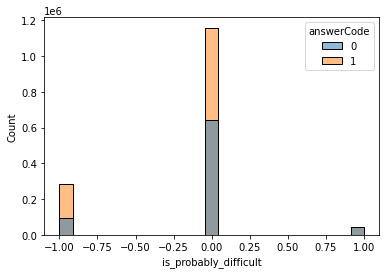

In [44]:
sns.histplot(data=train_df, x="is_probably_difficult", hue='answerCode')

In [45]:
# 전체 오답률
len(train_df[train_df.answerCode == 0]) / len(train_df)

0.34562156476745204

In [46]:
# is_probably_difficult == 1 일 때 오답률
pred_df = train_df.loc[train_df.is_probably_difficult == 1, :].copy()
len(pred_df[pred_df.answerCode == 0]) / len(pred_df)

0.5147172371838368

In [47]:
# is_probably_difficult == 0 일 때 오답률
pred_df = train_df.loc[train_df.is_probably_difficult == 0, :].copy()
len(pred_df[pred_df.answerCode == 0]) / len(pred_df)

0.3575856526952218